In [88]:
# LSTM 구조 및 설명
# LSTM 핵심은 이전 단계 정보를 memory cell에 저장하여 다음 단계로 전달
# 현재 시점의 정보를 바탕으로 과거 정보를 얼마나 잊을지 또는 기억할지 등을 계산하고, 그 결과에 현재 정보를 추가해서 다음 시점으로 정보를 전달함
# forget gate, input gate, cell state, output gate 등으로 구성
# gate는 memory cell에 정보를 저장하고 다음 단계로 전달하는 역할 수행

# forget gate
# Ft = sigmoid(Uf x Xt + Wf x Ht-1 + bf) 0~1 사이 값
# 계산값이 1에 가깝다면 과거 정보를 많이 활용, 0에 가깝다면 과거 정보를 많이 잃게 되는 원리

# input gate
# It = sigmoid(Uin x Xt + Win x Ht-1 + bi) 0~1 사이 값
# 'Ct = tanh(Uc x Xt + Wc x Ht-1 + bc)
# 현재 시점에서 실제로 갖고 있는 정보가 얼마나 중요한지를 반영하여 cell에 기록함

# cell state
# Ct = Ft x Ct-1 + It x 'Ct
# 과거의 정보를 forget gate 에서 계산된 만큼 잊고(또는 기억하고), 
# 현 시점의 정보값에 입력 게이트의 중요도 만큼 곱해준 것을 더해서 현재 시점 기준의 memory cell 값을 게산

# output gate
# Ot = sigmoid(Uo x Xt + Wo x Ht-1 + bo)
# Ht = Ot * tanh(Ct)
# output gate는 forget gate와 input gate에 의해서 변경된 현재 시점의 memory cell state(Ct) 값을
# 얼마나 빼내서 다음 레이어로 전달할지 결정하는 단계
# 현재 시점의 LSTM 출력값 Ht = Ot * tanh(Ct) 수식에서의 곱하기 표시는 pointwise operation

In [89]:
# LSTM을 이용한 삼성전자 주가 예측
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

# GPU 설정
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [90]:
# 삼성전자 주식 데이터 다운로드
!pip install finance-datareader

In [91]:
# 삼정전자 데이터 로드, 삼성전자(005930)
df = fdr.DataReader('005930', '2020-01-01', '2025-07-30')
# df.head(3)
df = df[ ['Open', 'High', 'Low', 'Volume', 'Close'] ]
df.head(10)

,Open,High,Low,Volume,Close
Date,,,,,
2020-01-02,55500,56000,55000,12993228,55200
2020-01-03,56000,56600,54900,15422255,55500
2020-01-06,54900,55600,54600,10278951,55500
2020-01-07,55700,56400,55600,10009778,55800
2020-01-08,56200,57400,55900,23501171,56800
2020-01-09,58400,58600,57400,24102579,58600
2020-01-10,58800,59700,58300,16000170,59500
2020-01-13,59600,60000,59100,11359139,60000
2020-01-14,60400,61000,59900,16906295,60000


In [92]:
# 하이퍼 파라미터
FEATURE_NUMS = 4        # 입력층으로 들어가는 데이터 개수 feature
SEQ_LENGTH = 5          # 정답을 만들기 위해 필요한 시점 개수 time step
HIDDEN_SIZE = 4         # RNN 계열 계층을 구성하는 hidden state 개수
NUM_LAYERS = 1          # RNN 계열 계층이 몇겹으로 쌓였는지 나타냄
LEARNING_RATE = 1e-3    # 학습율
BATCH_SIZE = 20         # 학습을 위한 배치사이즈 개수

# feature - 'Open', 'High', 'Low', 'Volume'
# label - 'Close'
# sequence(time step) - 5일치 데이터

In [93]:
# 데이터 스케일링 / 시퀀스 데이터 만들기
SPLIT = int(0.7 * len(df)) # train : test = 7 : 3

train_df = df[ :SPLIT]
test_df = df[SPLIT: ]

print(train_df.shape, test_df.shape)

(959, 5) (412, 5)


In [94]:
# 데이터 스케일링
scaler_x = MinMaxScaler() # feature scaling
train_df.iloc[ : , :-1] = scaler_x.fit_transform(train_df.iloc[ : , :-1])
test_df.iloc[ : , :-1] = scaler_x.fit_transform(test_df.iloc[ : , :-1])

# label scaling 별도로 하는 이유는 0~1 사이의 값을 원래의 값 50,000 등으로 변환하기 위함, inverse_transform() 함수 사용
scaler_y = MinMaxScaler() # label scaling
train_df.iloc[ : , -1] = scaler_y.fit_transform(train_df.iloc[ : , [-1]])
test_df.iloc[ : , -1] = scaler_y.fit_transform(test_df.iloc[ : , [-1]])

C:\Users\AI\AppData\Local\Temp\ipykernel_11596\493695545.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.27044025 0.28092243 0.25786164 0.27463312 0.2851153  0.3312369
 0.33962264 0.35639413 0.37316562 0.35429769 0.34591195 0.40461216
 0.4067086  0.4067086  0.37526205 0.40251572 0.35220126 0.34591195
 0.33962264 0.31865828 0.27044025 0.30398323 0.36477987 0.36687631
 0.38784067 0.34800839 0.360587   0.37106918 0.38993711 0.3836478
 0.39832285 0.38155136 0.360587   0.37945493 0.33962264 0.31027254
 0.2851153  0.28092243 0.28721174 0.25995807 0.24528302 0.29559748
 0.2557652  0.31446541 0.29140461 0.25366876 0.23480084 0.24528302
 0.17610063 0.10167715 0.1572327  0.09014675 0.10796646 0.07966457
 0.03249476 0.         0.02620545 0.13312369 0.13417191 0.14675052
 0.0932914  0.11320755 0.10167715 0.0754717  0.10062893 0.10272537
 0.14779874 0.14675052 0.14989518 0.13312369 0.12683438 0.12997904
 0.14150943 0.171

In [95]:
# 시퀀스 데이터 만들기
def MakeSeqNumpyData(data, seq_length):
    x_seq_list = []
    y_seq_list = []

    for i in range(len(data) - seq_length):
        x_seq_list.append(data[ i:i + seq_length, :-1]) # 5일치 학습데이터
        y_seq_list.append(data[ i + seq_length, [-1]]) # 6일째 정답데이터
    
    # numpy data
    x_seq_numpy = np.array(x_seq_list)
    y_seq_numpy = np.array(y_seq_list)

    return x_seq_numpy, y_seq_numpy

In [96]:
# 시퀀스 데이터 생성

# train
x_train_data, y_train_data = MakeSeqNumpyData(data=np.array(train_df), 
                                              seq_length=SEQ_LENGTH)
# test
x_test_data, y_test_data = MakeSeqNumpyData(data=np.array(test_df), 
                                              seq_length=SEQ_LENGTH)

print(x_train_data.shape, y_train_data.shape)
print(x_test_data.shape, y_test_data.shape)

(954, 5, 4) (954, 1)
(407, 5, 4) (407, 1)


In [97]:
# tensor data 생성

# train
x_train_tensor = torch.FloatTensor(x_train_data).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train_data).to(DEVICE)
# test
x_test_tensor = torch.FloatTensor(x_test_data).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test_data).to(DEVICE)

# TensorDataset 생성
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# DataLoader 생성
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [98]:
# model 구축
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # lstm hiddem state 0으로 초기화
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        # lstm cell state 0으로 초기화
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        outputs, _ = self.lstm(x, (h0, c0))
        last_hs = outputs[ :, -1, :]
        prediction = self.fc(last_hs)

        return prediction

In [99]:
# model 객체, 손실함수, 최적화 함수 생성

# LSTMModel(4, 4, 1)
model = LSTMModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)

# loss function
loss_function = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [100]:
# Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        
        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()

    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산

    return train_avg_loss

In [101]:
# model 학습
train_loss_list = []

EPOCHS = 200

for epoch in range(EPOCHS):

    train_avg_loss = model_train(dataloader=train_loader,
                           model=model,
                           loss_function=loss_function,
                           optimizer=optimizer)
    
    train_loss_list.append(train_avg_loss)

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss)
    )

epoch :  01 train loss =  0.193216
epoch :  02 train loss =  0.103917
epoch :  03 train loss =  0.051419
epoch :  04 train loss =  0.031208
epoch :  05 train loss =  0.025688
epoch :  06 train loss =  0.022678
epoch :  07 train loss =  0.019751
epoch :  08 train loss =  0.016887
epoch :  09 train loss =  0.014178
epoch :  10 train loss =  0.011672
epoch :  11 train loss =  0.009404
epoch :  12 train loss =  0.007408
epoch :  13 train loss =  0.005722
epoch :  14 train loss =  0.004370
epoch :  15 train loss =  0.003352
epoch :  16 train loss =  0.002637
epoch :  17 train loss =  0.002171
epoch :  18 train loss =  0.001884
epoch :  19 train loss =  0.001714
epoch :  20 train loss =  0.001613
epoch :  21 train loss =  0.001551
epoch :  22 train loss =  0.001510
epoch :  23 train loss =  0.001480
epoch :  24 train loss =  0.001456
epoch :  25 train loss =  0.001437
epoch :  26 train loss =  0.001420
epoch :  27 train loss =  0.001404
epoch :  28 train loss =  0.001390
epoch :  29 train lo

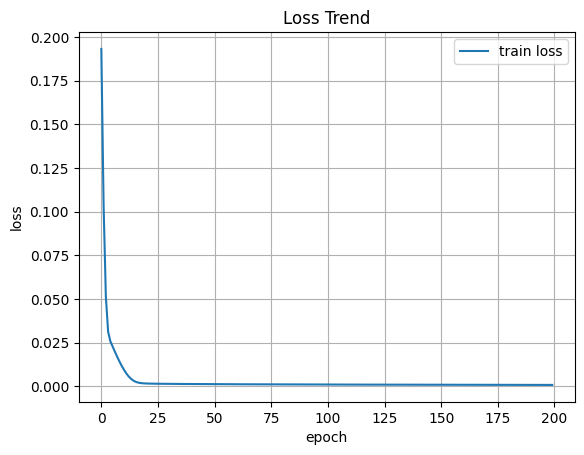

In [102]:
# 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.grid()
plt.legend(loc='best')
plt.show()

In [103]:
# 삼성전자 주가 예측

test_pred_tensor = model(x_test_tensor)

test_pred_numpy = test_pred_tensor.cpu().detach().numpy()

pred_inverse = scaler_y.inverse_transform(test_pred_numpy)

y_test_numpy = y_test_tensor.cpu().detach().numpy()

y_test_inverse = scaler_y.inverse_transform(y_test_numpy)


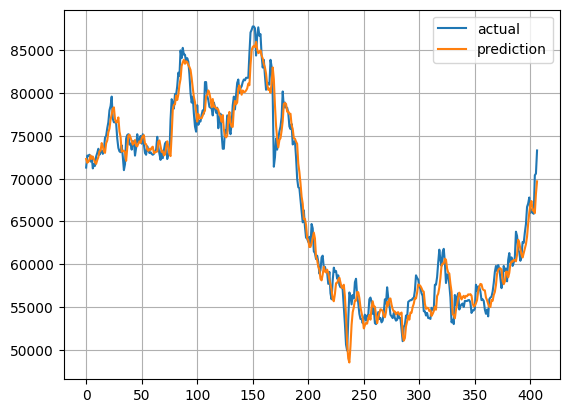

In [104]:
# 시각화 - 삼성전자 주가 예측, 원래 가격
plt.plot(y_test_inverse, label='actual')
plt.plot(pred_inverse, label='prediction')
plt.grid()
plt.legend()

plt.show()

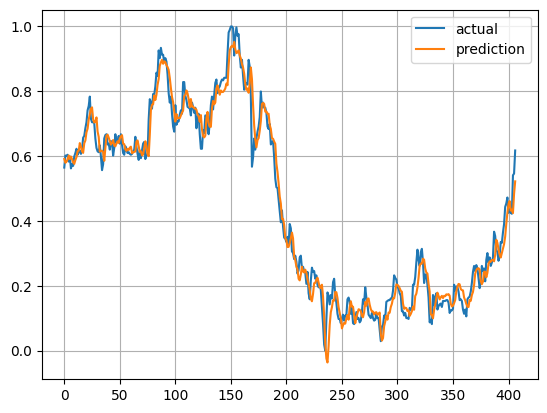

In [105]:
# 시각화 - 삼성전자 주가 예측, 너파이 가격
plt.plot(y_test_numpy, label='actual')
plt.plot(test_pred_numpy, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [106]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_lstm_stock.ckpt')